Theory : https://towardsdatascience.com/understanding-random-forest-58381e0602d2

Examples : https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

# Forests of randomized trees

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

from sklearn.utils import resample

### Set random seed to ensure reproducible runs

In [2]:
RSEED = 50

### Importing data and data cleaning

In [3]:
df_main = pd.read_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/df_main.csv', index_col='rgiid')
df_main.columns

Index(['Unnamed: 0', 'x', 'y', 'Surge', 'Area', 'Slope', 'TermType', 'Name',
       'bed', 'thickness', 'surface_elevation', 'ELA', 'beta', 'cmb',
       'width_centerline', 'Runoff'],
      dtype='object')

In [4]:
df_main.shape

(94234, 16)

In [5]:
df_main['WH'] = df_main['width_centerline'] / df_main['thickness']
df_main['WHsin'] = df_main['thickness']*df_main['width_centerline']*np.sin(df_main['Slope'])
df_main['dummy'] = np.random.rand(df_main.shape[0])

In [6]:
df_main.drop(df_main[df_main['Surge']==9].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==1].index, inplace = True)
df_main.drop(df_main[df_main['Surge']==2].index, inplace = True)
df = df_main.drop(columns = ['Unnamed: 0','x', 'y', 'ELA', 'beta', 'Name', 'Area'])
df.dropna(how='any', inplace=True)

In [7]:
df

,Surge,Slope,TermType,bed,thickness,surface_elevation,cmb,width_centerline,Runoff,WH,WHsin,dummy
rgiid,,,,,,,,,,,,
RGI60-07.00004,0,13.8,0,889.68555,25.314478,915.00000,1.392706,279.780932,1.100061,11.052210,6683.732353,0.459745
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.391001,295.980219,1.094416,9.567670,8640.744376,0.538373
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.389296,330.851846,1.088771,10.694908,9658.774620,0.383281
RGI60-07.00004,0,13.8,0,882.06460,30.935455,913.00000,1.387591,342.886985,1.083127,11.083948,10010.124318,0.848886
RGI60-07.00004,0,13.8,0,881.31860,34.681380,916.00000,1.385886,336.403639,1.077530,9.699834,11010.043050,0.225479
...,...,...,...,...,...,...,...,...,...,...,...,...
RGI60-07.01567,3,11.7,0,237.64468,50.380424,288.02512,-1.412920,278.553621,2.123592,5.529005,-10693.410549,0.793044
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.423469,256.755923,2.127417,5.495975,-9139.908345,0.258898
RGI60-07.01567,3,11.7,0,233.07228,46.717087,279.78937,-1.395654,238.477978,2.076787,5.104727,-8489.256385,0.643173


In [8]:
df_main.groupby('Surge').count()

,Unnamed: 0,x,y,Area,Slope,TermType,Name,bed,thickness,surface_elevation,ELA,beta,cmb,width_centerline,Runoff,WH,WHsin,dummy
Surge,,,,,,,,,,,,,,,,,,
0,68813,68813,68813,68813,68813,68813,48314,68813,68813,68813,68752,68752,68752,68707,68813,68707,68707,68813
3,10906,10906,10906,10906,10906,10906,10827,10906,10906,10906,10897,10897,10897,10905,10906,10905,10905,10906


In [9]:
df['Surge'] = df['Surge'].replace({3: 1})
df = df.loc[df['Surge'].isin([0, 1])].copy()
df = df.rename(columns = {'Surge': 'label'})
df['label'].value_counts()

0    68675
1    10897
Name: label, dtype: int64

In [10]:
df[df['label']==1].shape[0]

10897

In [11]:
df.shape

(79572, 12)

### Resampled

In [12]:
# Separate majority and minority classes
df_majority = df[df['label']==0]
df_minority = df[df['label']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df[df['label']==1].shape[0],     # to match minority class
                                 random_state=RSEED) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['label'].value_counts()
df = df_downsampled

In [13]:
df_downsampled.columns

Index(['label', 'Slope', 'TermType', 'bed', 'thickness', 'surface_elevation',
       'cmb', 'width_centerline', 'Runoff', 'WH', 'WHsin', 'dummy'],
      dtype='object')

In [14]:
# Extract the labels
labels = np.array(df.pop('label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = RSEED)

In [15]:
train_labels.sum()/train_labels.shape[0]

0.5000327761389708

In [16]:
test_labels.sum()/test_labels.shape[0]

0.499923535708824

In [17]:
missing_data = df.isna()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())
    print("")

Slope
False    21794
Name: Slope, dtype: int64

TermType
False    21794
Name: TermType, dtype: int64

bed
False    21794
Name: bed, dtype: int64

thickness
False    21794
Name: thickness, dtype: int64

surface_elevation
False    21794
Name: surface_elevation, dtype: int64

cmb
False    21794
Name: cmb, dtype: int64

width_centerline
False    21794
Name: width_centerline, dtype: int64

Runoff
False    21794
Name: Runoff, dtype: int64

WH
False    21794
Name: WH, dtype: int64

WHsin
False    21794
Name: WHsin, dtype: int64

dummy
False    21794
Name: dummy, dtype: int64



In [18]:
4081/81683

0.04996143628417174

In [19]:
# Features for feature importances
features = list(train.columns)
features

['Slope',
 'TermType',
 'bed',
 'thickness',
 'surface_elevation',
 'cmb',
 'width_centerline',
 'Runoff',
 'WH',
 'WHsin',
 'dummy']

In [20]:
train.shape

(15255, 11)

In [21]:
train_labels.shape

(15255,)

In [22]:
test.shape

(6539, 11)

### Evaluate the decision tree

In [23]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'm', label = 'model')
    plt.text(s = 'AUC = ' + str(round(roc_auc_score(train_labels, train_probs),2))
    , x=0.6, y=0.0, fontsize=15
)
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

# Logistic regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [28]:
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
    ]

In [36]:
# grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
grid={"C":np.arange(1e-5, 1e+5, 10), "penalty":["l1","l2", 'elasticnet']}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10, verbose=True, n_jobs=-1)

In [37]:
logreg_cv.fit(train, train_labels)
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

Fitting 10 folds for each of 30000 candidates, totalling 300000 fits


/home/colili/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.69026543        nan ...        nan 0.68803734        nan]
  warnings.warn(


tuned hpyerparameters :(best parameters)  {'C': 1e-05, 'penalty': 'l2'}
accuracy : 0.6902654319661389


In [44]:
logreg = LogisticRegression(C=1e-05, penalty='l2')
logreg.fit(train, train_labels)

LogisticRegression(C=1e-05)

In [45]:
predictions_LR = logreg.predict(test)
probs_LR = logreg.predict_proba(test)[:, 1]
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test, test_labels)))

Accuracy of logistic regression classifier on test set: 0.69


In [58]:
df.shape

(21794, 11)

In [52]:
test_labels.shape

(6539,)

In [50]:
MAE = mean_absolute_error(test, test_labels)

ValueError: y_true and y_pred have different number of output (11!=1)

In [53]:
test_labels.sum()

3269

In [54]:
pd.DataFrame({'true':test_labels, 'predictions':predictions_LR, 'prob':probs_LR}).to_csv('/home/colili/Documents/PhD/project_john/DataFrame_produced/ROC_curve/df_compare_roc_LR_centerline_resample_area.csv')

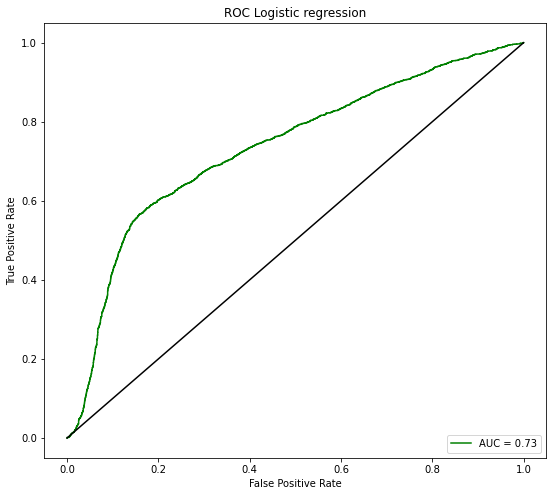

In [46]:
logit_roc_auc = roc_auc_score(test_labels, logreg.predict_proba(test)[:,1])
fpr, tpr, thresholds = roc_curve(test_labels, logreg.predict_proba(test)[:,1])
plt.figure(figsize=(9, 8))
plt.plot(fpr, tpr, 'g', label='AUC = %0.2f' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k')
# # plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Logistic regression')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

<function confusion_matrix at 0x7ff3ef8cdaf0>
Confusion matrix, without normalization
[[35 14]
 [16 33]]


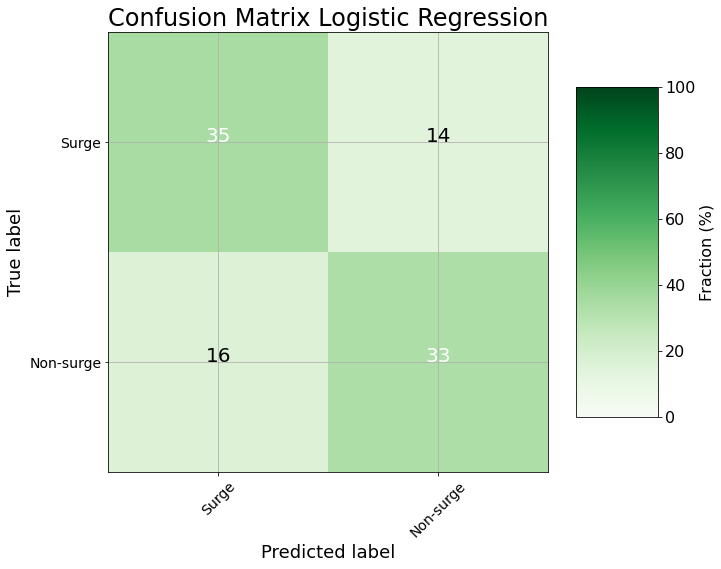

In [56]:
from sklearn.metrics import confusion_matrix
cm_LR = confusion_matrix(test_labels, predictions_LR)
print(confusion_matrix)
plot_confusion_matrix((cm_LR/test_labels.shape*100).astype(int), classes = ['Surge', 'Non-surge'],
                      title = 'Confusion Matrix Logistic Regression', cmap='Greens')

In [57]:
average_precision_LR = average_precision_score(test_labels, predictions_LR)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_LR))

Average precision-recall score: 0.63


Text(0.5, 1.0, '2-class Precision-Recall curve RF: AP=0.63')

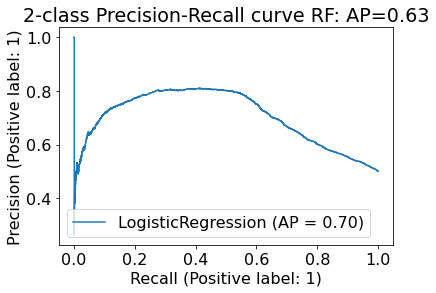

In [58]:
disp_lr = plot_precision_recall_curve(logreg, test, test_labels)
disp_lr.ax_.set_title('2-class Precision-Recall curve RF: '
                   'AP={0:0.2f}'.format(average_precision_LR))